##### Обучение байесовской сети

In [1]:
import pandas as pd
import xgboost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import os
from sklearn.linear_model import Lasso
import random
from bamt.networks.hybrid_bn import HybridBN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from pgmpy.estimators import K2Score, BicScore
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost
from scipy.spatial import distance
import IPython.display as display
from IPython.core.display import HTML
from scipy.stats import probplot

In [2]:
import bamt.preprocessors as pp
import pandas as pd
from sklearn import preprocessing

In [3]:
# импортируем данные кот у нас были в первой части
X_train = np.genfromtxt("data/X_train.csv")
y_train = np.genfromtxt("data/y_train.csv")
X_test = np.genfromtxt("data/X_test.csv")
y_test = np.genfromtxt("data/y_test.csv")
df_train = np.genfromtxt("data/df_train.csv")
df_test = np.genfromtxt("data/df_test.csv")
# импортируем результаты кот получили в первой части
hdi_RandomForest = np.genfromtxt("data/hdi_RandomForest.csv")
hdi_baes_regr_pymc = np.genfromtxt("data/hdi_baes_regr_pymc.csv")
hdi_RandomForest = np.genfromtxt("data/hdi_RandomForest.csv")  
est_baes_regr_pymc_MAPE_MSE = np.genfromtxt("data/est_baes_regr_pymc_MAPE_MSE.csv")
est_forest_SCIPY_MAPE_MSE = np.genfromtxt("data/est_forest_SCIPY_MAPE_MSE.csv")
est_lasso_SCIPY_MAPE_MSE = np.genfromtxt("data/est_lasso_SCIPY_MAPE_MSE.csv")
est_ridge_SCIPY_MAPE_MSE = np.genfromtxt("data/est_ridge_SCIPY_MAPE_MSE.csv")
est_lin_SCIPY_MAPE_MSE = np.genfromtxt("data/est_lin_SCIPY_MAPE_MSE.csv")

In [4]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [5]:
X_train.columns = ["'theta1'", "'theta2'", "'theta3'", "'theta4'", \
                  "'theta5'", "'theta6'", "'theta7'", "'theta8'"]
y_train.columns = ["'y'"]

In [6]:
X_test.columns = ["'theta1'", "'theta2'", "'theta3'", "'theta4'", \
                  "'theta5'", "'theta6'", "'theta7'", "'theta8'"]
y_test.columns = ["'y'"]

In [7]:
df_train.columns = ["'theta1'", "'theta2'", "'theta3'", "'theta4'", \
                    "'theta5'", "'theta6'", "'theta7'", "'theta8'", "'y'"]
df_train

'theta1'  'theta2'  'theta3'  'theta4'  'theta5'  'theta6'  'theta7'  \
0   -1.029760  0.479188  0.439449  1.248878  0.083688 -0.688224 -1.038145   
1    0.182539 -1.262926  0.740774  0.455410 -0.753353  1.304899 -0.754695   
2   -0.448522 -0.430705  1.374107 -0.210148 -0.898285  0.891416 -0.292980   
3    0.726180  1.042157  0.934746 -0.541922  0.321439  0.100698  1.016049   
4    1.356843 -0.107143  0.837890  0.832855 -0.381546  1.013895  0.860524   
..        ...       ...       ...       ...       ...       ...       ...   
995 -1.157468  0.872819  0.481487  0.667557  0.250813  1.489309  0.056486   
996  1.410080  0.567028  0.476840  0.531927  1.318313 -1.226619  0.181590   
997  0.389868 -0.589486  1.383079  1.453167 -1.464574  0.181372 -0.311207   
998 -1.309717 -0.528747  1.201081  0.017211  1.039627 -1.504107 -0.247552   
999 -0.938452  1.429913 -1.370521  1.062527 -0.563886 -1.125599  0.678879   

     'theta8'       'y'  
0    0.528458  0.899576  
1    0.589701  0.581259  
2   -1.299180  0.254927  
3    0.334679  0.725641  
4    0.776264  0.270745  
..        ...       ...  
995 -0.283560  0.142202  
996 -1.021786  0.844863  
997  0.759265  0.472024  
998 -0.952137  0.761341  
999 -1.065214  0.512856  

[1000 rows x 9 columns]

Для обучения баевской сети исспользуем библиотеку BAMT. Построим первую баевскую сеть на основе оценек К2 и гребневой регрессии

In [8]:
import bamt.networks as networks
from pgmpy.estimators import K2Score
from sklearn.linear_model import Ridge

In [9]:
bn_Ridge = networks.ContinuousBN(use_mixture=True)    # ContinuousBN - баевская сеть для непрерывных случайных велечин
# Если use_mixtureе=True, тогда миксеры гауссовских распределений используются для  
# представления условного распределения непрерывных переменных. Получаются лучше предсказания

In [10]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])

In [11]:
discretized_data, est = p.apply(df_train)

2023-11-04 08:56:55,367 | INFO     | preprocessors.py-scan-0107 | No one column is discrete


In [12]:
info = p.info
p.info

{'types': {"'theta1'": 'cont',
  "'theta2'": 'cont',
  "'theta3'": 'cont',
  "'theta4'": 'cont',
  "'theta5'": 'cont',
  "'theta6'": 'cont',
  "'theta7'": 'cont',
  "'theta8'": 'cont',
  "'y'": 'cont'},
 'signs': {"'theta1'": 'neg',
  "'theta2'": 'neg',
  "'theta3'": 'neg',
  "'theta4'": 'neg',
  "'theta5'": 'neg',
  "'theta6'": 'neg',
  "'theta7'": 'neg',
  "'theta8'": 'neg',
  "'y'": 'pos'}}

In [13]:
bn_Ridge.add_nodes(descriptor=info)   # добавляем узлы из информации, полученной в результате предварительной обработки

In [14]:
bn_Ridge.get_info(info)  

name        node_type data_type parents parents_types
0  'theta1'  MixtureGaussian      cont      []            []
1  'theta2'  MixtureGaussian      cont      []            []
2  'theta3'  MixtureGaussian      cont      []            []
3  'theta4'  MixtureGaussian      cont      []            []
4  'theta5'  MixtureGaussian      cont      []            []
5  'theta6'  MixtureGaussian      cont      []            []
6  'theta7'  MixtureGaussian      cont      []            []
7  'theta8'  MixtureGaussian      cont      []            []
8       'y'  MixtureGaussian      cont      []            []

In [15]:
# Структурное обучение баевской сети с использованием оценки K2 и гребневой регрессии
bn_Ridge.add_edges(discretized_data, scoring_function=('K2', K2Score), optimizer = "HC")
bn_Ridge.set_regressor({'y': Ridge()})
bn_Ridge.plot('Ridge_structure.html')                # чтобы получить график структуры

  0%|          | 0/1000000 [00:00<?, ?it/s]

####                                    Структура баевской сети на основе алгоритма гребневой регрессии:
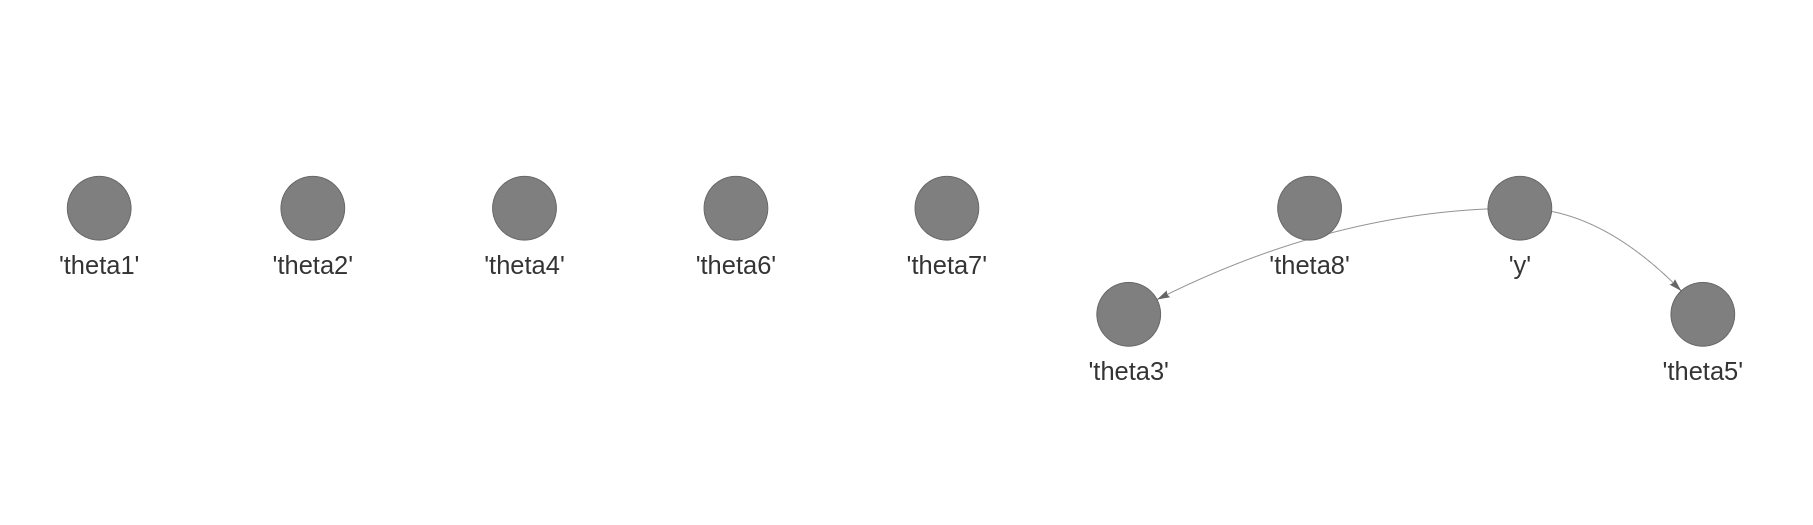

Как видим баевская сеть видит сильную связь theta5 и theta3 с 'y'. Заметим, что у этих переменных была максимальная корреляция с 'y'. Сами переменные между собой не отличались значительной корреляций, поэтому ребер (связей) не наблюдаем

In [16]:
bn_Ridge.fit_parameters(df_train)
sample_BN_Ridge = bn_Ridge.sample(1000)      # сэмплирование на основе обученной баевской сети (греб регрессии)
sample_BN_Ridge

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 283.80it/s]


'theta1'  'theta2'  'theta4'  'theta5'  'theta6'  'theta7'  'theta8'  \
0    0.022710  0.327771  0.843512  1.505679 -1.009762  1.214837  0.523160   
1   -1.369307 -0.821956 -0.481718 -0.989358  1.363366  0.704816 -0.134413   
2    1.532834  1.007985 -0.289735  0.531514  0.550846  1.311384  1.746993   
3   -0.781052  0.659525  1.288635 -1.470454 -0.375383  0.822239 -1.371514   
4   -0.937516 -0.492681 -1.261305 -0.827697 -1.331633  1.039420 -1.205450   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.822289  0.261997  1.332668 -0.023658  1.094866  0.634072 -1.112799   
996 -1.566122  0.230802 -0.880478  1.049657 -0.616940 -1.395948 -0.325103   
997 -1.335157 -0.743586  0.561698  1.431613 -1.287244  1.095364  1.118882   
998 -1.100356  0.647174 -0.518770 -0.724644  1.246851  0.029294  0.123943   
999 -1.227267  0.135056 -0.331397  1.408346 -1.319173  0.775475  0.531243   

          'y'  'theta3'  
0    0.860439  0.343198  
1    0.424119  0.235755  
2    0.303845  0.484433  
3    0.826531  0.294352  
4    0.560495 -0.022534  
..        ...       ...  
995  0.918406 -0.772739  
996  0.295467 -0.157119  
997  0.416096  0.772138  
998  0.468834 -0.279507  
999  0.631054 -0.016176  

[1000 rows x 9 columns]

In [17]:
y_pred_BN_Ridge = bn_Ridge.predict(X_test, parall_count=1) # parall_count - количество используемых параллельных потоков

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 516.48it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 581.57it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 443.23it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 518.84it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 424.87it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 600.64it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 501.89it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 449.60it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 696.03it/s]


100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 123.83it/s]


In [18]:
def def_error(y_test, y_pred, get_result=False):
    if get_result == True:
        return mean_absolute_percentage_error(y_test, y_pred), mean_squared_error(y_test, y_pred)
    else:
        print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}%', \
              f'MSE: {mean_squared_error(y_test, y_pred)}%', sep='\n')

In [19]:
def_error(np.array(y_test), np.array(y_pred_BN_Ridge["'y'"]), get_result=False)

MAPE: 0.4089446327845654%
MSE: 0.06231327331418064%


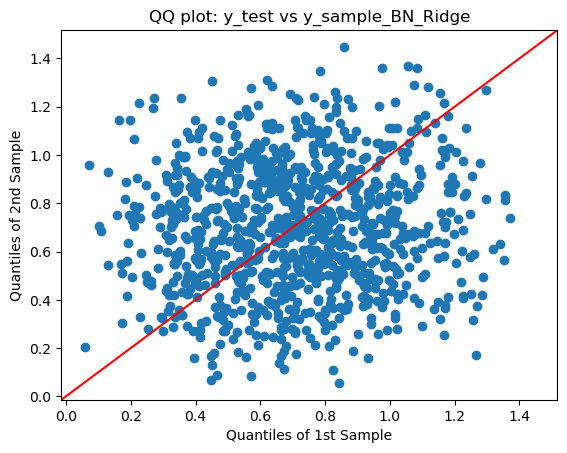

In [20]:
sm.qqplot_2samples(np.array(y_test), np.array(sample_BN_Ridge["'y'"]), line='45')
plt.title("QQ plot: y_test vs y_sample_BN_Ridge")
plt.show()

Как видим по графику QQ-плот 'y_test' и 'y_pred_BN_Ridge' (предсказанные с учетом параметров обученной баевской сети на основе гребневой регрессии) очен близки друг к дргу

Построим вторую баевскую сеть на основе RandomForestRegressor оценки BIC

In [21]:
from pgmpy.estimators import BicScore
from sklearn.ensemble import RandomForestRegressor

In [22]:
bn_RandomForest = networks.ContinuousBN(use_mixture=True)
bn_RandomForest.add_nodes(descriptor=info)
bn_RandomForest.add_edges(discretized_data, scoring_function=('BIC',BicScore))  
# фукция оценки= BicScore и на основе RandomForest регресии
bn_RandomForest.set_regressor({'y': RandomForestRegressor()})                  
bn_RandomForest.plot('RandomForestRegressor_structure.html')         

ITERATION:  0
Improved Arc Addition:  (0, 1)
Delta Score:  1664577.552789821
Improved Arc Addition:  (0, 2)
Delta Score:  1672077.5527898213
Improved Arc Addition:  (0, 3)
Delta Score:  1673677.5527898213
Improved Arc Addition:  (4, 6)
Delta Score:  1675877.5527898213
ADDING:  (4, 6) 

ITERATION:  1
Improved Arc Addition:  (0, 1)
Delta Score:  1664577.552789821
Improved Arc Addition:  (0, 2)
Delta Score:  1672077.5527898213
Improved Arc Addition:  (0, 3)
Delta Score:  1673677.5527898213
Improved Arc Addition:  (6, 5)
Delta Score:  1675677.5527898213
ADDING:  (6, 5) 

ITERATION:  2
Improved Arc Addition:  (0, 1)
Delta Score:  1664577.552789821
Improved Arc Addition:  (0, 2)
Delta Score:  1672077.5527898213
Improved Arc Addition:  (0, 3)
Delta Score:  1673677.5527898213
ADDING:  (0, 3) 

ITERATION:  3
Improved Arc Addition:  (0, 1)
Delta Score:  1664577.552789821
Improved Arc Addition:  (0, 2)
Delta Score:  1672077.5527898213
Improved Arc Addition:  (2, 7)
Delta Score:  1672877.552789821

####                                    Структура баевской сети на основе алгоритма RandomForest регрессии
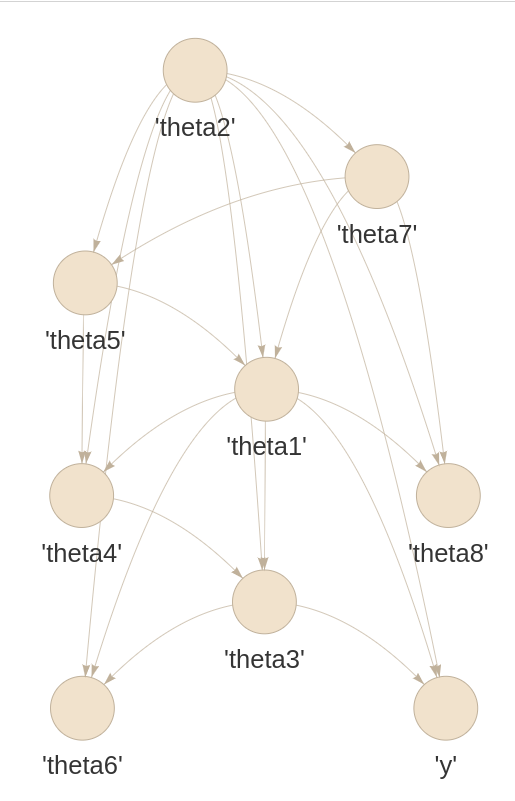

RandomForest лучше находит связи и зависимости в узлах, что и наблюдаем в графике структуры баевской сети

In [23]:
bn_RandomForest.fit_parameters(df_train)
sample_BN_RandomForest = bn_RandomForest.sample(1000) # сэмплирование на основе обученной баевской сети (RandomForestRegressor)
sample_BN_RandomForest

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 70.29it/s]


'theta2'  'theta5'  'theta7'  'theta6'  'theta3'  'theta1'  'theta4'  \
0    0.394987 -0.359028 -0.964076  0.772759  0.818974 -1.097916 -2.238781   
1    1.327602 -1.200052 -0.285048  0.444707 -0.591794 -1.258468 -0.901628   
2    1.489746  1.162345 -0.204960  0.374536 -0.974577 -0.077275  0.916041   
3   -0.492209  0.888981 -0.152440  0.494475 -1.187992  0.607870  0.071758   
4    0.921246  1.099614  0.431017  0.186932  0.603161 -1.216676  0.866473   
..        ...       ...       ...       ...       ...       ...       ...   
993 -0.331020  0.184902 -0.033371 -1.311646 -0.763323 -1.226765 -0.739360   
994 -0.754361 -1.505054  1.315621 -0.113174  1.151508 -0.273383  0.095608   
995 -0.139256 -1.185135  0.808370  0.418650 -0.165654  1.095106 -1.143584   
996 -0.061925  0.036415  0.129716  0.414129  1.555687  0.235051 -0.028797   
997  0.555488  0.171390  0.834449  0.328331  0.523951 -0.097806 -1.595738   

     'theta8'       'y'  
0   -0.203952  0.705433  
1   -0.778238  0.612462  
2    0.028211  0.648166  
3   -0.330327  1.376568  
4   -0.285533  0.813453  
..        ...       ...  
993 -0.104244  0.718273  
994  0.039093  0.727467  
995  0.462228  0.486709  
996  1.675427  0.603693  
997 -0.125034  0.875351  

[998 rows x 9 columns]

In [24]:
y_pred_BN_RandomForest = bn_RandomForest.predict(X_test, parall_count=1)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.08it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 400.45it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 481.88it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 509.39it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 397.72it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 378.82it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 502.43it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 440.21it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 329.35it/s]


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 106.64it/s]


In [25]:
def_error(np.array(y_test), np.array(y_pred_BN_RandomForest["'y'"])) # на основе баевской сети (RandomForest, BIC)

MAPE: 0.4270058089048262%
MSE: 0.0689232987574676%


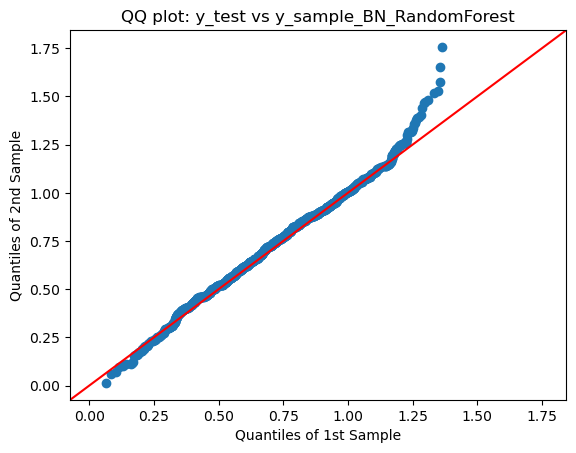

In [26]:
sm.qqplot_2samples(np.array(y_test), np.array(sample_BN_RandomForest["'y'"]), line='45')
plt.title("QQ plot: y_test vs y_sample_BN_RandomForest")
plt.show()

Как видим график QQ-plot лучше у баевской сети на основе гребневой регресии: график ближе к линии соответствия, что также отражается и в оценках MAPE и MSE

In [27]:
print("Оценки баевской сети на основе гребневой регресии и c K2Score")
def_error(np.array(y_test), np.array(y_pred_BN_Ridge["'y'"])),
print("")
print("Оценки баевской сети на основе  RandomForest-регресии и BicScore")
def_error(np.array(y_test), np.array(y_pred_BN_RandomForest["'y'"]))

Оценки баевской сети на основе гребневой регресии и c K2Score
MAPE: 0.4089446327845654%
MSE: 0.06231327331418064%

Оценки баевской сети на основе  RandomForest-регресии и BicScore
MAPE: 0.4270058089048262%
MSE: 0.0689232987574676%


##### Семплирование и вывод MAP оценки. Оценка байесовского интервала для апостериорного распределения

In [28]:
from scipy import stats
from statistics import mode

Сэмплированные данные можно получить с помощью метода bn_RandomForest.sample(1000) указав необходимое количество данных. Только предварительно нужно в баевской сеть обучить параметры с помощью bn_RandomForest.fit_parameters(df_train), передав данные. Сейчас сеть настроена на основе гребневой регрессии, сделаем сэмплирование

In [29]:
bn_RandomForest.fit_parameters(df_train)
sample_BN_RandomForest = bn_RandomForest.sample(1000) # сэмплирование на основе обученной баевской сети (RandomForestRegressor)
sample_BN_RandomForest

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.24it/s]


'theta2'  'theta5'  'theta7'  'theta6'  'theta3'  'theta1'  'theta4'  \
0   -1.393119 -0.684258 -0.392745 -1.490842  0.391468 -0.549862  0.448340   
1    1.554055 -0.750673 -1.307623 -0.435232 -0.678699 -0.744239 -0.475183   
2    0.602726  1.362819 -0.343918  0.880553 -0.774393  0.187469 -1.769443   
3    0.387557 -1.027740  1.354814 -0.081768  1.359745  0.231243 -0.862237   
4   -0.475479  0.562808 -0.138899  0.265137  1.453212 -0.653399  0.584307   
..        ...       ...       ...       ...       ...       ...       ...   
991  0.843711 -0.055854 -0.142412 -0.152374  0.835892 -0.384060 -0.015225   
992 -1.443112  0.805144  1.224480  0.514730 -1.428858  0.032230  1.209212   
993  0.186248  1.392717  0.373808  2.375064 -1.023348 -0.467243  1.375388   
994  0.518739 -1.290576 -1.012493 -0.334263  0.093925  0.817436  0.240664   
995 -0.841961 -0.576778 -0.704189 -1.317224  0.014008  0.673321  0.115726   

     'theta8'       'y'  
0   -1.832635  0.948096  
1   -1.642701  0.887810  
2   -0.965853  0.586383  
3   -0.246630  0.517627  
4   -0.306368  0.915738  
..        ...       ...  
991  0.155701  0.572488  
992  1.201888  0.507763  
993  0.826744  0.611320  
994 -0.322000  0.873299  
995 -0.531437  1.024344  

[996 rows x 9 columns]

Сэмплирование на основе баевской гребневой сети делается аналогично, сначало обучаем параметры fit_parameters(df_train), потом получаем сэмплы данных с помощью bn_RandomForest.sample(n=кол.экз) \
Выше это было продемонстрировано

In [30]:
# делаем порядок столбцов как у df_train, чтобы сравнить на графике "ящик с усами"
sample_BN_RandomForest = sample_BN_RandomForest[["'theta1'","'theta2'", "'theta3'", "'theta4'", \
                                                 "'theta5'", "'theta6'", "'theta7'","'theta8'", "'y'"]]

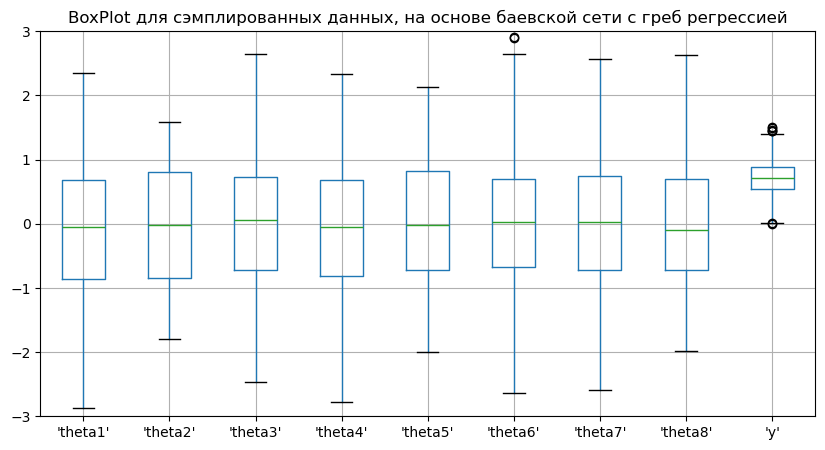

In [31]:
sample_BN_RandomForest.boxplot(figsize=(10,5), grid=True)
plt.title("BoxPlot для сэмплированных данных, на основе баевской сети с греб регрессией")
plt.ylim([-3, 3])
plt.show()

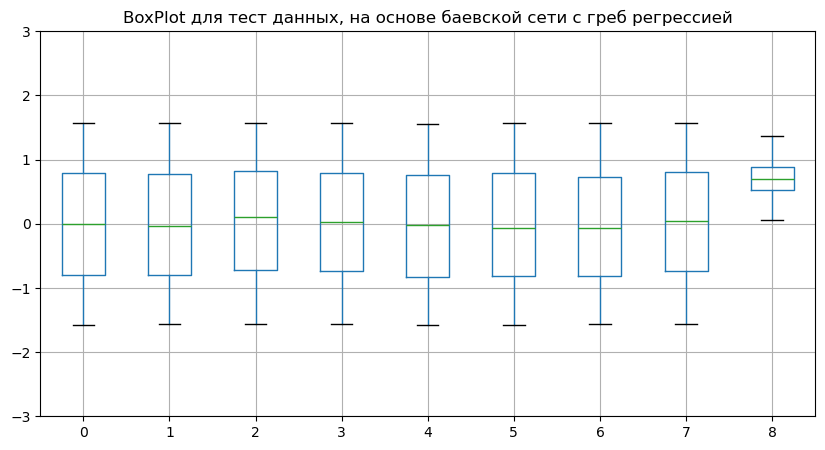

In [32]:
df_test.boxplot(figsize=(10,5), grid=True)
plt.title("BoxPlot для тест данных, на основе баевской сети с греб регрессией")
plt.ylim([-3, 3])
plt.show()

Как видим из boxplot квартили почти совпадаают, медиана тоже, у баевской сети побольше усы в основном и есть выбросы. Скорее всего качество было бы лучше, если бы данных взяли больше. В целях сокращения времени обучения скоратили данные до 1000 экз

In [33]:
fixed_values = {        # fixed_values - список соответствующих фиксированных значений
    "'theta1'": sample_BN_RandomForest["'theta1'"].mean(),
    "'theta2'": sample_BN_RandomForest["'theta2'"].mean(),
    "'theta3'": sample_BN_RandomForest["'theta3'"].mean(),
    "'theta4'": sample_BN_RandomForest["'theta4'"].mean(),
    "'theta5'": sample_BN_RandomForest["'theta5'"].mean(),
    "'theta6'": sample_BN_RandomForest["'theta6'"].mean(),
    "'theta7'": sample_BN_RandomForest["'theta7'"].mean(),
    "'theta8'": sample_BN_RandomForest["'theta8'"].mean(),
}
sample_length = len(sample_BN_RandomForest)
data = [fixed_values.copy() for _ in range(sample_length)]
sample_fixed = pd.DataFrame(data)

In [34]:
sample_fixed # сэмпл, где все переменные с фиксированными значениями

'theta1'  'theta2'  'theta3'  'theta4'  'theta5'  'theta6'  'theta7'  \
0   -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
1   -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
2   -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
3   -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
4   -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
..        ...       ...       ...       ...       ...       ...       ...   
991 -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
992 -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
993 -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
994 -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   
995 -0.057149 -0.020834  0.043959 -0.049186  0.016858  0.040905   0.02721   

     'theta8'  
0   -0.009466  
1   -0.009466  
2   -0.009466  
3   -0.009466  
4   -0.009466  
..        ...  
991 -0.009466  
992 -0.009466  
993 -0.009466  
994 -0.009466  
995 -0.009466  

[996 rows x 8 columns]

In [35]:
samples_modified = []   # - список cэмплов полученных при фиксированных значениях
for i, column in enumerate(fixed_values.keys()):
    samples_modified.append(sample_fixed.copy())
    samples_modified[i][column] = sample_BN_RandomForest[column]    # меняем фикс столбец не не столбец из сэмпла

In [36]:
samples_modified[1]    # сэмпл, где все переменные с фиксированными (средним) значениями, кроме 1го столбца

'theta1'  'theta2'  'theta3'  'theta4'  'theta5'  'theta6'  'theta7'  \
0   -0.057149 -1.393119  0.043959 -0.049186  0.016858  0.040905   0.02721   
1   -0.057149  1.554055  0.043959 -0.049186  0.016858  0.040905   0.02721   
2   -0.057149  0.602726  0.043959 -0.049186  0.016858  0.040905   0.02721   
3   -0.057149  0.387557  0.043959 -0.049186  0.016858  0.040905   0.02721   
4   -0.057149 -0.475479  0.043959 -0.049186  0.016858  0.040905   0.02721   
..        ...       ...       ...       ...       ...       ...       ...   
991 -0.057149  0.843711  0.043959 -0.049186  0.016858  0.040905   0.02721   
992 -0.057149 -1.443112  0.043959 -0.049186  0.016858  0.040905   0.02721   
993 -0.057149  0.186248  0.043959 -0.049186  0.016858  0.040905   0.02721   
994 -0.057149  0.518739  0.043959 -0.049186  0.016858  0.040905   0.02721   
995 -0.057149 -0.841961  0.043959 -0.049186  0.016858  0.040905   0.02721   

     'theta8'  
0   -0.009466  
1   -0.009466  
2   -0.009466  
3   -0.009466  
4   -0.009466  
..        ...  
991 -0.009466  
992 -0.009466  
993 -0.009466  
994 -0.009466  
995 -0.009466  

[996 rows x 8 columns]

In [37]:
predictions_BN_RandomForest = []         #  - список массивов с прогнозами при фиксированных значениях
for i in range(len(samples_modified)):
    prediction = bn_RandomForest.predict(test=samples_modified[i], parall_count=2)
    predictions_BN_RandomForest.append(prediction)

0


100%|██████████| 1/1 [00:00<00:00, 462.13it/s]          | 0/996 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 440.86it/s]

100%|██████████| 1/1 [00:00<00:00, 473.02it/s]

100%|██████████| 1/1 [00:00<00:00, 560.21it/s]


100%|██████████| 1/1 [00:00<00:00, 506.86it/s]


100%|██████████| 1/1 [00:00<00:00, 509.76it/s]

100%|██████████| 1/1 [00:00<00:00, 638.40it/s]


100%|██████████| 1/1 [00:00<00:00, 490.73it/s]

100%|██████████| 1/1 [00:00<00:00, 643.69it/s]


100%|██████████| 1/1 [00:00<00:00, 519.68it/s]

100%|██████████| 1/1 [00:00<00:00, 414.13it/s]


100%|██████████| 1/1 [00:00<00:00, 559.46it/s] 996/996 [00:06<00:00, 159.22it/s]

100%|██████████| 1/1 [00:00<00:00, 527.59it/s]

100%|██████████| 1/1 [00:00<00:00, 542.53it/s]


1


100%|██████████| 1/1 [00:00<00:00, 405.40it/s]

100%|██████████| 1/1 [00:00<00:00, 554.66it/s]


100%|██████████| 1/1 [00:00<00:00, 536.29it/s]

100%|██████████| 1/1 [00:00<00:00, 673.89it/s]


100%|██████████| 1/1 [00:00<00:00, 528.38it/s]

100%|██████████| 1/1 [00:00<00:00, 624.99it/s]


100%|██████████| 1/1 [00:00<00:00, 586.45it/s]


100%|██████████| 1/1 [00:00<00:00, 587.36it/s]


100%|██████████| 1/1 [00:00<00:00, 638.40it/s]

100%|██████████| 1/1 [00:00<00:00, 620.00it/s]


2


100%|██████████| 1/1 [00:00<00:00, 394.87it/s]

100%|██████████| 1/1 [00:00<00:00, 579.88it/s]

100%|██████████| 1/1 [00:00<00:00, 685.34it/s]


100%|██████████| 1/1 [00:00<00:00, 568.72it/s]

100%|██████████| 1/1 [00:00<00:00, 580.45it/s]


100%|██████████| 1/1 [00:00<00:00, 512.50it/s]

100%|██████████| 1/1 [00:00<00:00, 511.94it/s]

100%|██████████| 1/1 [00:00<00:00, 614.28it/s]


100%|██████████| 1/1 [00:00<00:00, 680.56it/s]


100%|██████████| 1/1 [00:00<00:00, 549.35it/s]

100%|██████████| 1/1 [00:00<00:00, 493.62it/s]

100%|██████████| 1/1 [00:00<00:00, 418.30it/s]


100%|██████████| 1/1 [00:00<00:00, 548.28it/s] 996/996 [00:02<00:00, 365.59it/s]

100%|██████████| 1/1 [00:00<00:00, 504.91it/s]


3


100%|██████████| 1/1 [00:00<00:00, 487.20it/s]


100%|██████████| 1/1 [00:00<00:00, 454.22it/s]

100%|██████████| 1/1 [00:00<00:00, 609.19it/s]


100%|██████████| 1/1 [00:00<00:00, 511.31it/s]

100%|██████████| 1/1 [00:00<00:00, 404.23it/s]

100%|██████████| 1/1 [00:00<00:00, 678.36it/s]


100%|██████████| 1/1 [00:00<00:00, 403.30it/s]


100%|██████████| 1/1 [00:00<00:00, 513.50it/s]

100%|██████████| 1/1 [00:00<00:00, 576.54it/s]


100%|██████████| 1/1 [00:00<00:00, 366.09it/s] 996/996 [00:02<00:00, 355.69it/s]

100%|██████████| 1/1 [00:00<00:00, 657.83it/s]

100%|██████████| 1/1 [00:00<00:00, 462.54it/s]

100%|██████████| 1/1 [00:00<00:00, 574.72it/s]


4


100%|██████████| 1/1 [00:00<00:00, 367.76it/s]

100%|██████████| 1/1 [00:00<00:00, 521.74it/s]

100%|██████████| 1/1 [00:00<00:00, 537.59it/s]


100%|██████████| 1/1 [00:00<00:00, 545.92it/s]


100%|██████████| 1/1 [00:00<00:00, 678.80it/s]


100%|██████████| 1/1 [00:00<00:00, 580.53it/s]

100%|██████████| 1/1 [00:00<00:00, 509.76it/s]


100%|██████████| 1/1 [00:00<00:00, 621.19it/s]


100%|██████████| 1/1 [00:00<00:00, 505.40it/s]


5


100%|██████████| 1/1 [00:00<00:00, 566.11it/s]

100%|██████████| 1/1 [00:00<00:00, 624.62it/s]


100%|██████████| 1/1 [00:00<00:00, 337.76it/s]

100%|██████████| 1/1 [00:00<00:00, 507.48it/s]

100%|██████████| 1/1 [00:00<00:00, 281.50it/s]


100%|██████████| 1/1 [00:00<00:00, 435.36it/s]

100%|██████████| 1/1 [00:00<00:00, 562.69it/s]

100%|██████████| 1/1 [00:00<00:00, 540.22it/s]


100%|██████████| 1/1 [00:00<00:00, 494.20it/s]

100%|██████████| 1/1 [00:00<00:00, 548.13it/s]


100%|██████████| 1/1 [00:00<00:00, 529.52it/s]

100%|██████████| 1/1 [00:00<00:00, 385.36it/s]

100%|██████████| 1/1 [00:00<00:00, 502.91it/s]

100%|██████████| 1/1 [00:00<00:00, 508.46it/s]

100%|██████████| 1/1 [00:00<00:00, 514.39it/s]


100%|██████████| 1/1 [00:00<00:00, 545.42it/s]


6


100%|██████████| 1/1 [00:00<00:00, 349.53it/s]

100%|██████████| 1/1 [00:00<00:00, 519.68it/s]


100%|██████████| 1/1 [00:00<00:00, 498.55it/s]

100%|██████████| 1/1 [00:00<00:00, 500.51it/s]

100%|██████████| 1/1 [00:00<00:00, 510.82it/s]

100%|██████████| 1/1 [00:00<00:00, 510.19it/s]


100%|██████████| 1/1 [00:00<00:00, 540.22it/s]

100%|██████████| 1/1 [00:00<00:00, 342.53it/s]



100%|██████████| 1/1 [00:00<00:00, 549.06it/s]

100%|██████████| 1/1 [00:00<00:00, 511.75it/s]

100%|██████████| 1/1 [00:00<00:00, 538.42it/s]

100%|██████████| 1/1 [00:00<00:00, 650.68it/s]


100%|██████████| 1/1 [00:00<00:00, 654.24it/s]

100%|██████████| 1/1 [00:00<00:00, 596.80it/s]

100%|██████████| 1/1 [00:00<00:00, 553.63it/s]

100%|██████████| 1/1 [00:00<00:00, 424.14it/s]


100%|██████████| 1/1 [00:00<00:00, 650.08it/s]


7


100%|██████████| 1/1 [00:00<00:00, 626.67it/s]

100%|██████████| 1/1 [00:00<00:00, 577.81it/s]

100%|██████████| 1/1 [00:00<00:00, 594.43it/s]


100%|██████████| 1/1 [00:00<00:00, 619.45it/s]


100%|██████████| 1/1 [00:00<00:00, 608.84it/s]

100%|██████████| 1/1 [00:00<00:00, 581.73it/s]


100%|██████████| 1/1 [00:00<00:00, 560.14it/s]

100%|██████████| 1/1 [00:00<00:00, 569.34it/s]

100%|██████████| 1/1 [00:00<00:00, 303.56it/s]

100%|██████████| 1/1 [00:00<00:00, 589.67it/s]


100%|██████████| 1/1 [00:00<00:00, 505.52it/s]

100%|██████████| 1/1 [00:00<00:00, 513.69it/s]


100%|██████████| 1/1 [00:00<00:00, 329.90it/s]

100%|██████████| 1/1 [00:00<00:00, 488.79it/s]

100%|██████████| 1/1 [00:00<00:00, 634.06it/s]


MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta1' 0.83
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta2' 0.8
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta3' 0.8
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta4' 0.8
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta5' 0.8
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta6' 0.8
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta7' 0.8
MAP оценка для 'y', полученная при всех фикс переменный кроме 'theta8' 0.62


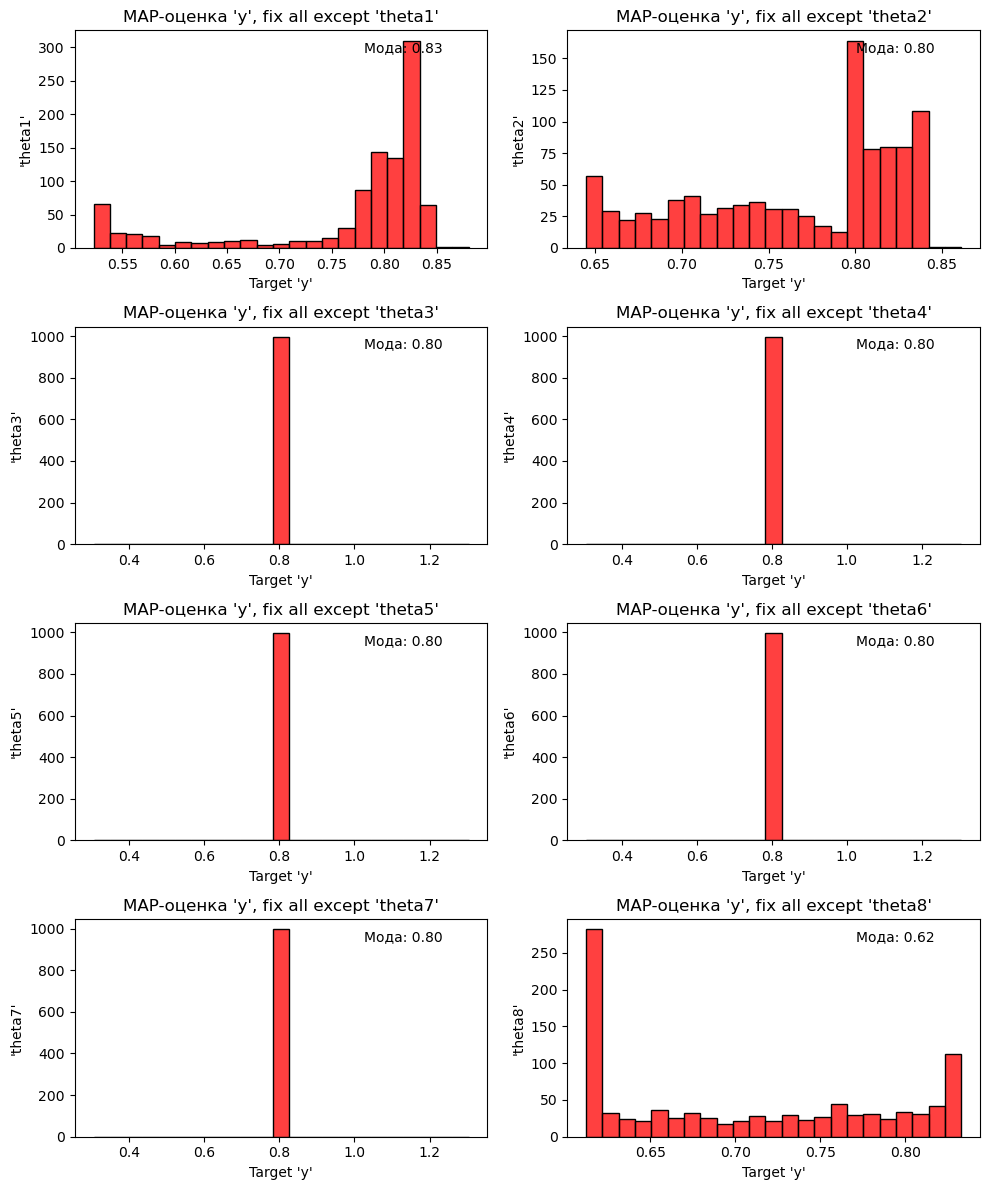

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Список для хранения информации о mode_bin
mode_bin_info = []

# Перебираем прогнозы и вычисляем информацию о гистограмме
for prediction in predictions_BN_RandomForest:
    histogram, bin_edges = np.histogram(prediction["'y'"], bins=23, density=True)
    # Найдем бин с наивысшей частотой
    mode_bin = np.argmax(histogram)
    # Сохраним информацию о mode_bin
    mode_bin_info.append({
        'bin_edges': bin_edges,
        'mode_bin_edge_left': bin_edges[mode_bin],
        'mode_bin_edge_right': bin_edges[mode_bin + 1],
        'mode_bin_count': histogram[mode_bin]
    })
num_rows = 4
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 12))
# Перебирем информацию о mode_bin и создадим графики распределения
for i, info in enumerate(mode_bin_info):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    # Создадим гистограмму для столбца 'y'
    sns.histplot(predictions_BN_RandomForest[i]["'y'"], kde=False, color='red', bins=info['bin_edges'], ax=ax) 
#     sns.plot_errorbaras(0.1,0.5)
    ax.set_xlabel("Target 'y'")           # Метка по оси X
    ax.set_ylabel(list(fixed_values)[i])  # Метка по оси Y
#     plt.axvline(baes_intervals_BN_RandomForest[0][1], color='red',  linewidth=2)  # upper bound
#     plt.axvline(baes_intervals_BN_RandomForest[0][0], color='red', linewidth=2)   # lower bound
    ax.set_title(f"MAP-оценка 'y', fix all except {list(fixed_values)[i]}")  
    # Отображение моды на графике
    ax.text(0.7, 0.9, f'Мода: {((info["mode_bin_edge_right"] + info["mode_bin_edge_left"]) / 2):.2f}', \
            transform=ax.transAxes)
    print("MAP оценка для 'y', полученная при всех фикс переменный кроме", f"'theta{i+1}'", 
          round(((info["mode_bin_edge_right"] + info["mode_bin_edge_left"]) / 2),2))
plt.tight_layout()
plt.show()  

In [39]:
mode(y_pred_BN_RandomForest["'y'"])       # MAP оценка предсказанных 'y' с помощью баевской сети RandomForest, BIC

0.7095612795990381

In [40]:
baes_intervals_BN_RandomForest = np.zeros((len(predictions_BN_RandomForest), 2))

In [41]:
import arviz as az
for i in range(len(predictions_BN_RandomForest)):
    baes_interval = az.hdi(np.array(predictions_BN_RandomForest[i]["'y'"]), hdi_prob=0.95)
    print("Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме", f"'theta{i+1}'", 
          np.round(baes_interval,2))
    baes_intervals_BN_RandomForest[i] += baes_interval

Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta1' [0.52 0.84]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta2' [0.65 0.84]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta3' [0.8 0.8]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta4' [0.8 0.8]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta5' [0.8 0.8]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta6' [0.8 0.8]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta7' [0.8 0.8]
Баевский интервал 95% доверия для 'y', полученный при всех фикс переменный кроме 'theta8' [0.61 0.83]


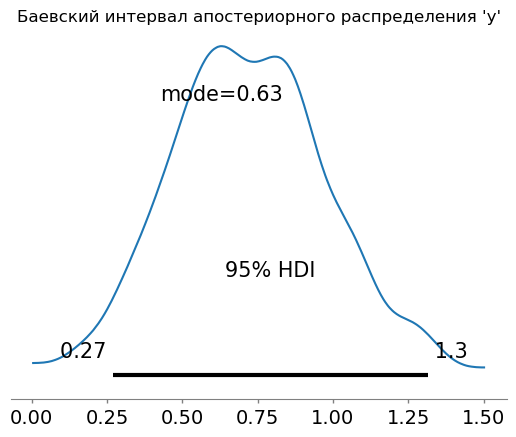

In [42]:
az.plot_posterior(np.array(sample_BN_RandomForest["'y'"]), hdi_prob=0.95, point_estimate="mode")
plt.title("Баевский интервал апостериорного распределения 'y'")
plt.show()

In [43]:
az.hdi(np.array(sample_BN_RandomForest["'y'"]), hdi_prob=0.95)  # Баевский интервал 95% доверия для 'y'

array([0.26932059, 1.31378733])

В этом интервале с 95% вероятностью будут находиться истинные значения

##### Анализ и сравнение точечных и интервальных оценок регрессионных предсказаний

In [44]:
print("")
print("Lasso регрессия, SCIPY билблиотека:")
print("MAPE:", est_lasso_SCIPY_MAPE_MSE[0])
print("MSE:", est_lasso_SCIPY_MAPE_MSE[1])
print("------------------------------------------------------")
print("Ridge регрессия, SCIPY билблиотека:")
print("MAPE:", est_ridge_SCIPY_MAPE_MSE[0])
print("MSE:", est_ridge_SCIPY_MAPE_MSE[1])
print("------------------------------------------------------")
print("Линейная регрессия, SCIPY билблиотека:")
print("MAPE:", est_lin_SCIPY_MAPE_MSE[0])
print("MSE:", est_lin_SCIPY_MAPE_MSE[1])
print("------------------------------------------------------")
print("RandomForest, SCIPY билблиотека:")
print("MAPE:", est_forest_SCIPY_MAPE_MSE[0])
print("MSE:", est_forest_SCIPY_MAPE_MSE[1])
print("Доверительный интервал 95% доверия", hdi_RandomForest)
print("------------------------------------------------------")
print("Баевская регрессия, pymc билблиотека:")
print("MAPE:", est_baes_regr_pymc_MAPE_MSE[0])
print("MSE:", est_baes_regr_pymc_MAPE_MSE[1])
print("Баевский интервал 95% доверия", hdi_baes_regr_pymc)
print("------------------------------------------------------")
print("Баевская сеть на основе (Ridge, K2):")
def_error(np.array(y_test), np.array(y_pred_BN_Ridge["'y'"]))
print("MAP оценка", mode(y_pred_BN_Ridge["'y'"]))
print("Баевский интервал 95% доверия", az.hdi(np.array(sample_BN_Ridge["'y'"]), hdi_prob=0.95))
print("------------------------------------------------------")
print("Баевская сеть на основе (RandomForest, BIC):")
def_error(np.array(y_test), np.array(y_pred_BN_RandomForest["'y'"])) 
print("MAP оценка", mode(y_pred_BN_RandomForest["'y'"]))
print("Баевский интервал 95% доверия", az.hdi(np.array(sample_BN_RandomForest["'y'"]), hdi_prob=0.95))
print("")


Lasso регрессия, SCIPY билблиотека:
MAPE: 0.42529836983865504
MSE: 0.0671624543455859
------------------------------------------------------
Ridge регрессия, SCIPY билблиотека:
MAPE: 0.323955043267416
MSE: 0.04102341672883547
------------------------------------------------------
Линейная регрессия, SCIPY билблиотека:
MAPE: 0.32392820522285887
MSE: 0.04102525215180944
------------------------------------------------------
RandomForest, SCIPY билблиотека:
MAPE: 0.27967434703527705
MSE: 0.03003395826341241
Доверительный интервал 95% доверия [0.39357358 1.00895898]
------------------------------------------------------
Баевская регрессия, pymc билблиотека:
MAPE: 0.5603770508364416
MSE: 0.1331560262420398
Баевский интервал 95% доверия [0.19728111 1.189121  ]
------------------------------------------------------
Баевская сеть на основе (Ridge, K2):
MAPE: 0.4089446327845654%
MSE: 0.06231327331418064%
MAP оценка 0.7073123490035438
Баевский интервал 95% доверия [0.23532714 1.21463217]
------

Построенные модели регрессии на основе баевского подхода показали хороший результат, оценки сильно не отличаются. Если сравнивать точечные оценки с интервальными, то считаем что интервальные лучше использовать на маленькой выборке. MAP оценка с фиксированными переменными не много отличалась (от переменной к переменной), но в целом если взять интервал от минимальной MAP оценки до максимальной MAP оценки, это все равно получим более узкий диапазон, более точную оценку